## STERNUM

In [1]:
import pandas as pd
import numpy as np

from scipy import signal
import scipy.linalg as la
from scipy.stats import norm
from scipy.integrate import trapz
import math as m
import pywt

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
from matplotlib.gridspec import GridSpec

In [2]:
# colors
colA = 'royalblue'
colG = 'darkorange'
colM = 'brown'

## Load the orginal data

In [3]:
# original dataset
DF = pd.read_csv('center_sternum.txt',sep='\t')  
DF

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
0,5,200,1576222772,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178,0.792622,0.254952,-0.553850,-0.000031
1,5,200,1576222772,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177,0.736461,0.275124,-0.617969,0.006806
2,5,200,1576222772,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177,0.729465,0.275246,-0.626118,0.009827
3,5,200,1576222772,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176,0.723413,0.277200,-0.632221,0.011383
4,5,200,1576222772,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176,0.721948,0.280007,-0.632679,0.010193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16501,5,200,1576222847,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126,0.650810,0.379162,-0.636402,0.166356
16502,5,200,1576222847,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125,0.650239,0.379803,-0.636708,0.165960
16503,5,200,1576222847,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125,0.649365,0.380627,-0.637227,0.165502
16504,5,200,1576222847,965.630,300.852,-56.242,0.702290,3.664122,-1.587786,-495,-448,-124,0.648973,0.381329,-0.637348,0.164953


## Select only the meaningful data

From the sampling frequency of the dataset (Log Freq = 200 Hz), we obtained the time vector (in seconds) associated to the measurement. 
In order to select only a meaningful time interval for the data, we plotted AccX, GyroX and MagnX as a function of time. 
As we can see from the plot, at the beginning and at the end of the dataset, there are some irregularities, so we cropped it in the interval $[7.5,70]s$. Then time was rescaled to bring the first measure to $0 s$.



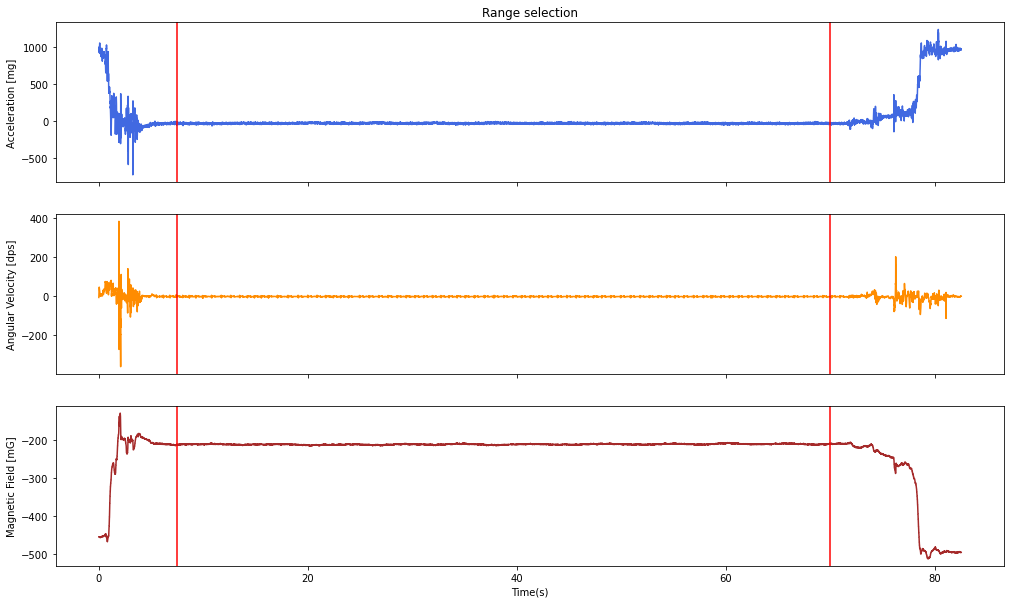

In [4]:
# plot raw data
(fig, (ax1,ax2,ax3)) = plt.subplots(3,1,figsize=(17,10), sharex=True)

t = np.arange(0, len(DF['AccX']))/DF['Log Freq'][0]
ax1.plot(t, DF['AccX'], color=colA)
ax1.axvline(x = 7.5, color = 'red')
ax1.axvline(x = 70, color = 'red')
ax1.set_ylabel('Acceleration [mg]')
ax1.set_title('Range selection')

ax2.plot(t, DF['GyroX'], color=colG)
ax2.axvline(x = 7.5, color = 'red')
ax2.axvline(x = 70, color = 'red')
ax2.set_ylabel('Angular Velocity [dps]')

ax3.plot(t, DF['MagnX'], color=colM)
ax3.axvline(x = 7.5, color = 'red')
ax3.axvline(x = 70, color = 'red')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Magnetic Field [mG]') 

plt.show()

The most interesting columns are the ones with the measurements of accelerometer(mg), gyroscope(dps), and magnetometer(mG), and corresponding time(s). Quaternion data was neglected as the quality of the signal is poor and the information they bring is redundant.

In [5]:
# new dataset with only the interesting data
a = 1500
b = 14000
freq = DF['Log Freq'][0]
df = DF.iloc[a:b+1]    
df = df.drop(['Log Mode', 'Log Freq', 'Timestamp','qw', 'qi', 'qj', 'qk'], axis=1) 
df['Time'] = np.arange(0, len(df['AccX']))/freq
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
1500,-24.949,115.046,-951.661,0.687023,4.870229,1.511450,-212,-434,435,0.000
1501,-10.980,106.323,-971.059,1.358779,3.358779,1.099237,-212,-435,435,0.005
1502,-17.690,109.800,-970.022,1.068702,3.160305,0.702290,-213,-435,434,0.010
1503,-21.533,104.249,-965.630,0.687023,2.793893,0.381679,-213,-435,434,0.015
1504,-23.668,104.737,-967.033,0.305343,2.748092,0.778626,-214,-435,435,0.020
...,...,...,...,...,...,...,...,...,...,...
13996,-30.866,118.767,-941.108,-3.175573,3.358779,-0.778626,-210,-430,427,62.480
13997,-32.818,118.279,-942.145,-2.992366,3.679389,-0.549618,-210,-430,427,62.485
13998,-22.692,113.704,-948.184,-3.022901,3.786260,-0.564885,-211,-432,427,62.490
13999,-38.674,119.743,-937.143,-2.854962,3.419847,-0.885496,-211,-432,427,62.495


## Calibration

Here we show the calibration procedure of the dataset, according to file "README1.TXT"

In [6]:
# calibration matrices and offset vectors
gyro_off = np.array([-2.242224,2.963463,-0.718397])
acc_cal = np.array([[1.000966,-0.002326418,-0.0006995499],
                    [-0.002326379,0.9787045,-0.001540918],
                    [-0.0006995811,-0.001540928,1.00403]])
acc_off = np.array([-3.929942,-13.74679,60.67546])
magn_cal=np.array([[0.9192851,-0.02325168,0.003480837],
                   [-0.02325175,0.914876,0.004257396],
                   [0.003481006,0.004257583,0.8748001]])
magn_off=np.array([-95.67974,-244.9142,17.71132])

In [7]:
# calibration procedure
df[['GyroX','GyroY','GyroZ']] = df[['GyroX','GyroY','GyroZ']] + gyro_off.T
df[['AccX','AccY','AccZ']] = np.dot(df[['AccX','AccY','AccZ']],acc_cal.T) + acc_off.T
df[['MagnX','MagnY','MagnZ']] = np.dot(df[['MagnX','MagnY','MagnZ']],magn_cal.T) + magn_off.T
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
1500,-28.504953,100.373720,-894.980558,-1.555201,7.833692,0.793053,-278.962788,-635.189046,395.663599,0.000
1501,-14.488596,91.833874,-914.453062,-0.883445,6.322242,0.380840,-278.939536,-636.103922,395.659342,0.005
1502,-21.213892,95.250842,-913.412547,-1.173522,6.123768,-0.016107,-279.862302,-636.084927,394.781061,0.010
1503,-25.050763,89.820226,-908.991605,-1.555201,5.757356,-0.336718,-279.862302,-636.084927,394.781061,0.015
1504,-27.187979,90.304963,-910.399517,-1.936881,5.711555,0.060229,-280.778107,-636.057418,395.652380,0.020
...,...,...,...,...,...,...,...,...,...,...
13996,-34.443708,104.012984,-884.386623,-5.417797,6.322242,-1.497023,-277.245071,-631.610104,388.689191,62.480
13997,-36.395733,103.541515,-885.425685,-5.234590,6.642852,-1.268015,-277.245071,-631.610104,388.689191,62.485
13998,-26.245083,99.049690,-891.489056,-5.265125,6.749723,-1.283282,-278.117853,-633.416605,388.677195,62.490
13999,-42.264295,104.980254,-880.401686,-5.097186,6.383310,-1.603893,-278.117853,-633.416605,388.677195,62.495


## Statistical analysis:

Mean, median, variance, standard deviation, 25th and 75th percentiles:

In [8]:
# statistical descriptors
stat_df = pd.DataFrame({
    'mean'  : df.mean(),
    'median': df.median(),
    'variance': df.var(),
    'standard deviation': df.std(),
    '25% percentile' : df.quantile(q=0.25),
    '75% percentile': df.quantile(q=0.75)
    }).T
stat_df.drop(['Time'], axis=1)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
mean,-34.309794,100.734210,-892.685252,-4.328721,6.644769,-1.585265,-278.662436,-633.718653,391.202763
median,-34.260318,100.958415,-893.069606,-4.394896,6.597051,-1.573359,-278.962788,-633.416605,391.286894
variance,49.866401,29.206212,212.532768,2.080482,0.532462,0.145359,1.437342,3.149817,6.780515
standard deviation,7.061615,5.404277,14.578504,1.442388,0.729700,0.381260,1.198892,1.774772,2.603942
25% percentile,-38.950034,97.321571,-901.411472,-4.944514,6.230639,-1.832901,-279.099931,-635.184788,388.689191
75% percentile,-29.601040,104.292364,-884.704283,-3.707873,6.963463,-1.344351,-278.046984,-632.478477,393.907037


We use the mean to center the data around 0 in the y-axis. Variance tells which component has bigger variability (as we will see later in the PCA procedure).

Correlation coefficients:

In [9]:
# corr.coeff.
M = df.loc[:,:'MagnZ'].corr()  
M

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
AccX,1.000000,-0.175850,-0.406324,0.211097,0.006664,0.027037,-0.380642,-0.022166,0.071081
AccY,-0.175850,1.000000,0.173606,-0.049653,0.000488,-0.103754,0.233688,0.353350,-0.491820
AccZ,-0.406324,0.173606,1.000000,-0.079548,0.117838,0.019098,0.119201,0.202044,-0.247645
GyroX,0.211097,-0.049653,-0.079548,1.000000,0.400553,0.368676,-0.061395,-0.057079,0.024329
GyroY,0.006664,0.000488,0.117838,0.400553,1.000000,0.426017,0.012710,-0.129760,0.021824
GyroZ,0.027037,-0.103754,0.019098,0.368676,0.426017,1.000000,-0.011409,-0.072499,0.012388
MagnX,-0.380642,0.233688,0.119201,-0.061395,0.012710,-0.011409,1.000000,0.216823,-0.307836
MagnY,-0.022166,0.353350,0.202044,-0.057079,-0.129760,-0.072499,0.216823,1.000000,-0.744287
MagnZ,0.071081,-0.491820,-0.247645,0.024329,0.021824,0.012388,-0.307836,-0.744287,1.000000


Correlation coefficients are not usually very high, probably due to signal intensity, which is not big with respect to signal noise. The most significant correlations are between the directional components of the same instrument.

## Centering the data


In [10]:
# centered dataset
dfc = df - stat_df.iloc[0]
dfc['Time'] = df['Time']
dfc

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
1500,5.804840,-0.360490,-2.295306,2.773520,1.188923,2.378318,-0.300352,-1.470393,4.460836,0.000
1501,19.821197,-8.900336,-21.767811,3.445276,-0.322527,1.966105,-0.277100,-2.385269,4.456578,0.005
1502,13.095901,-5.483368,-20.727295,3.155199,-0.521001,1.569158,-1.199866,-2.366275,3.578297,0.010
1503,9.259030,-10.913984,-16.306353,2.773520,-0.887413,1.248547,-1.199866,-2.366275,3.578297,0.015
1504,7.121814,-10.429248,-17.714266,2.391840,-0.933214,1.645494,-2.115670,-2.338766,4.449616,0.020
...,...,...,...,...,...,...,...,...,...,...
13996,-0.133915,3.278773,8.298629,-1.089076,-0.322527,0.088242,1.417365,2.108548,-2.513572,62.480
13997,-2.085940,2.807305,7.259567,-0.905869,-0.001917,0.317250,1.417365,2.108548,-2.513572,62.485
13998,8.064710,-1.684520,1.196196,-0.936404,0.104954,0.301983,0.544584,0.302048,-2.525569,62.490
13999,-7.954502,4.246044,12.283566,-0.768465,-0.261459,-0.018628,0.544584,0.302048,-2.525569,62.495


## PCA

Since the measurements of Accelerometer, Gyroscope, Magnetometer are performed along x,y,z-axes, we applied PCA analysis, in order to rotate the dataset and mantain only the component with major variability.

In [11]:
N = dfc.shape[0]

#Acc
U_acc,D_diag_acc,_=la.svd(dfc[['AccX','AccY','AccZ']].T)
avl_acc = np.real_if_close(D_diag_acc)**2/(N-1)
avl_acc_n = avl_acc/avl_acc.sum()

#Gyro
U_gyro,D_diag_gyro,_=la.svd(dfc[['GyroX','GyroY','GyroZ']].T)
avl_gyro = np.real_if_close(D_diag_gyro)**2/(N-1)
avl_gyro_n = avl_gyro/avl_gyro.sum()

#Magn
U_magn,D_diag_magn,_=la.svd(dfc[['MagnX','MagnY','MagnZ']].T)
avl_magn = np.real_if_close(D_diag_magn)**2/(N-1)
avl_magn_n = avl_magn/avl_magn.sum()

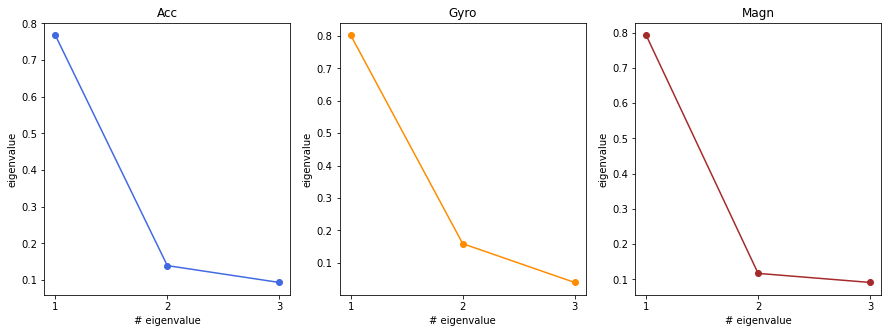

In [12]:
#Plot
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax1.plot(np.arange(U_acc.shape[0])+1, avl_acc_n, color = colA, marker = 'o')
ax1.set_title('Acc')
ax1.set_xlabel('# eigenvalue')
ax1.set_ylabel('eigenvalue')
ax1.xaxis.set_major_locator(MultipleLocator(1.000))
ax2.plot(np.arange(U_gyro.shape[0])+1, avl_gyro_n, color = colG, marker = 'o')
ax2.set_title('Gyro')
ax2.set_xlabel('# eigenvalue')
ax2.set_ylabel('eigenvalue')
ax2.xaxis.set_major_locator(MultipleLocator(1.000))
ax3.plot(np.arange(U_magn.shape[0])+1, avl_magn_n, color = colM, marker = 'o')
ax3.set_title('Magn')
ax3.set_xlabel('# eigenvalue')
ax3.set_ylabel('eigenvalue')
ax3.xaxis.set_major_locator(MultipleLocator(1.000))
plt.show()

In [13]:
print('Eigenvalues and eigenvectors (Acc): \n', avl_acc, '\n\n',U_acc, '\n')
print('Eigenvalues and eigenvectors (Gyro): \n', avl_gyro, '\n\n',U_gyro, '\n')
print('Eigenvalues and eigenvectors (Magn): \n', avl_magn, '\n\n',U_magn, '\n')

Eigenvalues and eigenvectors (Acc): 
 [223.79621083  40.60562833  27.20354118] 

 [[-0.23593172 -0.93513285 -0.26431569]
 [ 0.07623228  0.25334565 -0.96436747]
 [ 0.96877493 -0.24767426  0.01151503]] 

Eigenvalues and eigenvectors (Gyro): 
 [2.21252496 0.43814605 0.10763217] 

 [[-0.96234803  0.26653218 -0.05335597]
 [-0.2491525  -0.94340978 -0.21886303]
 [-0.10867058 -0.19732864  0.9742957 ]] 

Eigenvalues and eigenvectors (Magn): 
 [9.00334116 1.32824113 1.03609186] 

 [[-0.13892355  0.9203879   0.36549468]
 [-0.5098297  -0.38287722  0.7703757 ]
 [ 0.84898406 -0.07931672  0.52243175]] 



From PCA we can see that for the accelerometer Z-component is the most relevant, for gyroscope it is X, and Z for magnetometer.
This is in agreement with the orientation of the sensor, whose Z-axis is dorso-to-ventral direction, X-axis is foot-to-head directed and Y-axis is left-to-right. 

We notice that the first principal component contains about $80 \%$ of variability, so in the following analysis we will consider only this one for each instrument.
Thus, data was rotated according to the new axes:

In [14]:
# rotated dataset after PCA
rot = np.dot(dfc[['AccX','AccY','AccZ']],U_acc)
rot1 = np.dot(dfc[['GyroX','GyroY','GyroZ']],U_gyro)
rot2 = np.dot(dfc[['MagnX','MagnY','MagnZ']],U_magn)
dfr = pd.DataFrame({'Acc1': rot[:,0], 'Acc2': rot[:,1],'Acc3': rot[:,2],
                    'Gyro1': rot1[:,0], 'Gyro2': rot1[:,1],'Gyro3': rot1[:,2],
                    'Magn1': rot2[:,0], 'Magn2': rot2[:,1],'Magn3': rot2[:,2]})

dfr['Time'] = dfc['Time'].values
dfr


,Acc1,Acc2,Acc3,Gyro1,Gyro2,Gyro3,Magn1,Magn2,Magn3,Time
0,-3.620661,-4.951137,-1.213096,-3.223768,-0.851720,1.908990,4.578555,-0.067279,1.087950,0.000
1,-26.443051,-15.398988,3.093484,-3.448854,0.834583,1.802331,5.038141,0.304745,0.389426,0.005
2,-23.587832,-8.501977,1.587854,-3.077112,1.022839,1.474503,4.411004,-0.482168,-0.392049,0.010
3,-18.813683,-7.384770,7.890016,-2.583671,1.330052,1.262692,4.411004,-0.482168,-0.392049,0.015
4,-19.636443,-4.914679,7.971240,-2.248087,1.193202,1.679825,5.263942,-1.404706,-0.250373,0.020
...,...,...,...,...,...,...,...,...,...,...
12496,8.321046,-1.099466,-3.030988,1.118839,-0.003412,0.214672,-3.405889,0.696579,0.829244,62.480
12497,7.739033,0.863841,-2.072332,0.837763,-0.302238,0.357848,-3.405889,0.696579,0.829244,62.485
12498,-0.872291,-8.264608,-0.493359,0.842180,-0.408187,0.321212,-2.373816,0.585901,-0.887704,62.490
12499,14.100415,5.471909,-1.850801,0.806698,0.045518,0.080076,-2.373816,0.585901,-0.887704,62.495


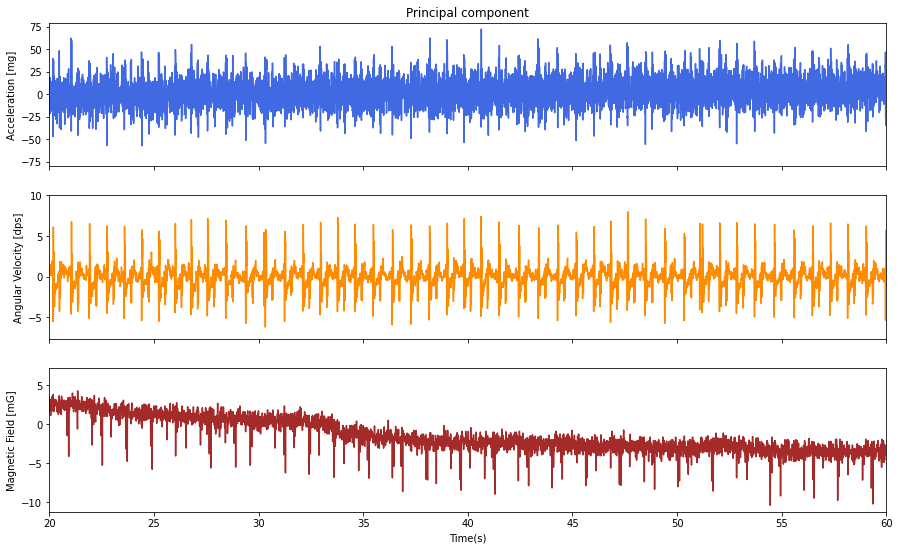

In [15]:
# principal component plots
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(15,9),sharex=True)
ax[0].plot(dfr['Time'],dfr['Acc1'],color=colA)
ax[0].set_ylabel('Acceleration [mg]')
ax[0].set_title('Principal component')

ax[1].plot(dfr['Time'],dfr['Gyro1'],color=colG)
ax[1].set_ylabel('Angular Velocity [dps]')

ax[2].plot(dfr['Time'],dfr['Magn1'],color=colM)
ax[2].set_ylabel('Magnetic Field [mG]')
ax[2].set_xlim(20,60)
ax[2].set_xlabel('Time(s)')

plt.show()

## FFT analysis

For each principal component, Fast Fourier Transform was calculated in order to highlight the heart-beat frequency in the spectrum, which should be between $[40,100]$ BPM.

heart beat freq acc = 1.152 +/- 0.009 
heart beat freq gyro = 1.152 +/- 0.009 


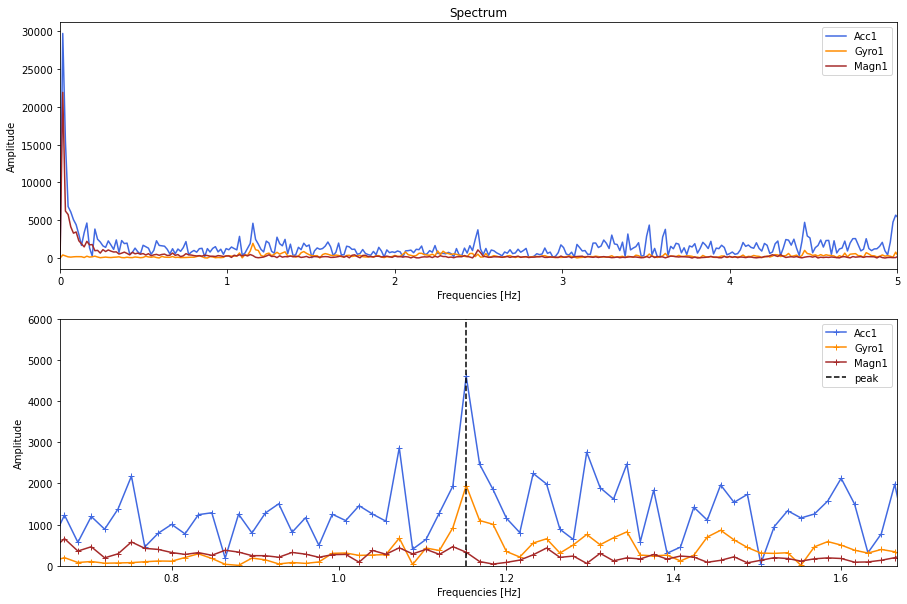

In [16]:
# HeartBeat freq
min_f=40./60.
max_f=100./60.

# FFT
A1_FFT = np.abs(np.fft.rfft(dfr['Acc1']))
G1_FFT = np.abs(np.fft.rfft(dfr['Gyro1']))
M1_FFT = np.abs(np.fft.rfft(dfr['Magn1']))
freq_FFT = np.fft.rfftfreq(d=1/freq, n=len(dfr['Acc1']))

X = []
YA = []
YG = []
for i in range(len(A1_FFT)):
    if freq_FFT[i]<=max_f and freq_FFT[i]>=min_f:
        X.append(freq_FFT[i])
        YA.append(A1_FFT[i])
        YG.append(G1_FFT[i])
        
peakA,_ = signal.find_peaks(YA, height=4000)
peakG,_ = signal.find_peaks(YG, height=1500)

print('heart beat freq acc = %.3f +/- %.3f ' % (X[peakA[0]] ,0.009))
print('heart beat freq gyro = %.3f +/- %.3f ' % (X[peakG[0]] ,0.009))

# spectrum
fig, (ax1,ax2) = plt.subplots(2,1,figsize = (15,10))
ax1.plot(freq_FFT, A1_FFT,color=colA, label='Acc1')
ax1.plot(freq_FFT, G1_FFT,color=colG, label='Gyro1')
ax1.plot(freq_FFT, M1_FFT,color=colM, label='Magn1')
ax1.set_xlim(0,5)
ax1.legend(loc='best')
ax1.set_xlabel('Frequencies [Hz]')
ax1.set_title('Spectrum')
ax1.set_ylabel('Amplitude')

ax2.plot(freq_FFT, A1_FFT,'-+',color=colA, label='Acc1')
ax2.plot(freq_FFT, G1_FFT,'-+',color=colG, label='Gyro1')
ax2.plot(freq_FFT, M1_FFT,'-+',color=colM, label='Magn1')
plt.axvline(x = X[peakG[0]], color='k', linestyle='dashed', label='peak')
ax2.set_xlim(min_f, max_f)
ax2.set_ylim(0,6000)
ax2.legend(loc='best')
ax2.set_xlabel('Frequencies [Hz]')
ax2.set_ylabel('Amplitude')

plt.show()

We notice that Magnetometer doesn't display any relevant peaks, then we will focus on the analysis of the other instruments form now on.

On their spectra between $[40,100]$ BPM, in fact, it is possible to distinguish a peak that is the same for both Accelerometer and Gyroscope (with this sampling frequency). This peak is at $1.152 \pm 0.009$ Hz, that corresponds to $69$ BPM. The estimated error is calculated from the sampling frequency interval.

The analysis of this spectrum cannot show anything about heart rate variability during the data taking time interval. Moreover, the presence of multiple peaks around the higher one (which are acceptable heart-beat frequencies as well) suggests us that the heart beat may vary during time.

For this reason we decide to make a more accurate analysis, that takes care of both time and frequency.

## SIGNAL PROCESSING

Our aim is to perform a peak analysis on the signal, in order to identify the periodicity of heart beat along time.
For this reason we need to clean the signal and, as far as possible, to highlight the major peaks.

Our first idea was to apply a FFT pass-band filter, with a band in physical heart frequencies.
Anyway, the peaks identifying the heart-beat are very fast in time, about $0.05 s$, which corresponds to a frequency of $20$ Hz. But we cannot take the Fourier band this wide, as this would not clean properly the signal, which would remain very noisy.

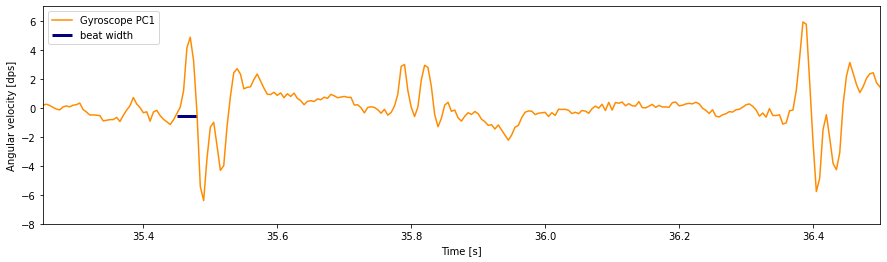

Beat width, example: 0.03 s


In [18]:
plt.figure(figsize=(15,4))
plt.plot(dfr['Time'],-dfr['Gyro1'],label='Gyroscope PC1',color=colG)
plt.xlim(35.25,36.5)
plt.ylim(-8,7)

plt.ylabel('Angular velocity [dps]')
plt.xlabel('Time [s]')
plt.hlines(-dfr['Gyro1'].values[3544],35.45,35.48,color='navy',linewidth=3,label='beat width')

plt.legend()
plt.show()

print('Beat width, example: 0.03 s')

Our signal processing pipeline was the following:

- Discrete wavelet transform: We used a level 3 dwt and neglected the first detailed coefficients and the approximation coefficients as each level splits the frequency band into two portions. In this way the selected frequencies are between $[12.5,50] Hz$ as required before
- Signal envelope: to highlight the periodicity of the fast peaks so obtained from the wavelet analysis. It develops low frequencies.  
- Bandpass filter (40-200)BPM: Filter of the FFT spectrum around relevant frequencies. 

[_Wenyan Jia et al., "Estimation of heart rate from a chest-worn inertial measurement unit", 2015 International Symposium on Bioelectronics and Bioinformatics (ISBB), Beijing, 2015, pp. 148-151, doi: 10.1109/ISBB.2015.7344945._](https://ieeexplore.ieee.org/document/7344945)

[_Yue-Der Lin, Ya-Fen Jhou, "Estimation of heart rate and respiratory rate from the seismocardiogram under resting state
", Biomedical Signal Processing and Control, Volume 57, March 2020, 101779, ISSN 1746-8094._ ](http://www.sciencedirect.com/science/article/pii/S174680941930360X)


## Fare plot heart beat ingrandito

In [ ]:
sigA = dfr['Acc1']
sigG = dfr['Gyro1']
t = dfr['Time']

In [ ]:
# wavelet
def wavelet_decomposition(t, signal, n, color):
    coeff = pywt.wavedec(signal, 'sym4', level = n)
    sigs = np.zeros((n+1,len(t)+1))
    for i in range(n+1):
        ca = coeff.copy()
        for j in range(n+1):
            if j != i: 
                ca[j] = np.zeros_like(ca[j])
        sigs[i] = pywt.waverec(ca, 'sym4')
    ax = []
    fig, ax = plt.subplots(nrows = n+1, ncols = 1, figsize = (15, 5), sharex=True)
    ax[n].set_xlabel('Time [s]')
    for i in range(n+1):
        ax[i].plot(t, sigs[i][:-1], color = color)
    return coeff

In [ ]:
# bandpass filter
def FILTER(SIG,f1,f2):
    FFT = np.fft.rfft(SIG)
    freq = np.fft.rfftfreq(len(SIG), 1/200)
    filt = np.zeros_like(freq)
    filt[(freq>f1) & (freq<f2)] = 1
    for i in range(len(freq)):
        if freq[i] > f1:
            filt[i-1] = 2/3
            filt[i-2] = 1/3
            break
    for i in range(len(freq)):
        if freq[i] > f2:
            filt[i] = 2/3
            filt[i+1] = 1/3
            break
    new_FFT = FFT*filt
    new_SIG = np.fft.irfft(new_FFT, len(SIG))
    return new_SIG


## Gyroscope

In [ ]:
n=4
CG = wavelet_decomposition(t, sigG, n, colG)

In [ ]:
# filtered signal after wavelet decomposition
cg = CG.copy()
for j in range(n+1):
    if (j!=1) & (j!=2) & (j!=3): 
        cg[j] = np.zeros_like(cg[j])
sigG_w = pywt.waverec(cg, 'sym4')
SIGG = sigG_w[:-1]

plt.figure(figsize=(15,5))
plt.plot(t, SIGG, color = colG)
plt.xlabel('Time [s]')
plt.ylabel('Angular Velocity [dps]')
plt.title('Wavelet Filtered Signal')

plt.show()

In [ ]:
# envelope
SIGG_h = np.abs(signal.hilbert(SIGG))

plt.figure(figsize=(15,5))
plt.plot(t, SIGG, colG,label='wavelet signal')
plt.plot(t, SIGG_h, color = 'r',alpha=0.8, linewidth=2, label='envelope')
plt.legend(loc='best')
plt.xlim(20, 30)
plt.ylabel('Angular Velocity [dps]')
plt.xlabel('Time [s]')

plt.show()

In [ ]:
# signal filtered with bandpass filter
f1 = 0.66
f2 = 6

signal_G = FILTER(SIGG_h,f1,f2)

plt.figure(figsize=(15,5))
plt.plot(t, signal_G , colG)
plt.xlim(20, 30)
plt.ylabel('Angular Velocity [dps]')
plt.xlabel('Time [s]')
plt.title('Filtered Signal')

## Accelerometer

In [ ]:
CA = wavelet_decomposition(t, sigA, n, colA)

In [ ]:
# filtered signal after wavelet decomposition
ca = CA.copy()
for j in range(n+1):
    if (j!=1) & (j!=2) & (j!=3): 
        ca[j] = np.zeros_like(ca[j])
sigA_w = pywt.waverec(ca, 'sym4')
SIGA = sigA_w[:-1]

plt.figure(figsize=(15,5))
plt.plot(t, SIGA, color = colA)
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [mg]')
plt.title('Wavelet Filtered Signal')

In [ ]:
# envelope
SIGA_h = np.abs(signal.hilbert(SIGA))

plt.figure(figsize=(15,5))
plt.plot(t, SIGA, colA, label='wavelet signal')
plt.plot(t, SIGA_h, color ='red', alpha=0.8, linewidth=3, label='envelope')
plt.legend(loc='best')
plt.xlim(20, 30)
plt.ylabel('Accelerationa [mg]')
plt.xlabel('Time [s]')

In [ ]:
# signal filtered with bandpass filter
f1 = 0.66
f2 = 6

signal_A = FILTER(SIGA_h,f1,f2)

plt.figure(figsize=(15,5))
plt.plot(t, signal_A , colA)
plt.xlim(20, 30)
plt.ylabel('Acceleration [mg]')
plt.xlabel('Time [s]')
plt.title('Filtered Signal')

## Find peaks

After the filtering, we can proceed analysing the distance between peaks, in order to obtain heart rate variability and BPM histogram.

In [ ]:
# function to plot HRV and BPM histo
def histo_func(bins1,peaks1,t,color,label):
    peaks_time1=t[peaks1]
    period1 = peaks_time1[1:]-peaks_time1[:-1]
    rate1 = 1/period1*60

    fig = plt.figure(figsize=(12,6))
    gs = GridSpec(3,3)

    ax_main = fig.add_subplot(gs[:,:2])
    ax_marg = fig.add_subplot(gs[:,2])
    ax_main.plot((peaks_time1[1:]+peaks_time1[:-1])*0.5,rate1,marker='o',color=color, label=label)
    ax_main.legend()
    ax_main.set_xlabel('Time (s)')
    ax_main.set_ylabel('Heart BPM')
    ax_main.set_title('Heart Rate Variability and BPM histogram')
    l=ax_main.get_ylim()
    h1,b1,_=ax_marg.hist(x=rate1, bins=bins1,orientation='horizontal',color=color)
    bin_center1=(b1[1:]+b1[:-1])*0.5
    ax_marg.set_ylim(l)

In [ ]:
# gyroscope peaks
%matplotlib inline
plt.figure(figsize=(15,5))
plt.plot(t,sigG, color='grey',alpha=0.4,label='original signal')
plt.plot(t,signal_G,label='filtered signal',color=colG)
peaksG,_ = signal.find_peaks(signal_G, height=0.3 , distance=100)
plt.plot(t[peaksG],signal_G[peaksG], 'rx', label='peaks')
plt.xlim(20,40)
plt.ylabel('Angular Velocity [dps]')
plt.xlabel('Time [s]')
plt.legend(loc='upper right')
plt.title('Peaks Detection')

In [ ]:
# HRV and BPM histo
histo_func(15,peaksG,t.values,colG,'Gyroscope')

In [ ]:
# accelerometer peaks
%matplotlib inline
plt.figure(figsize=(15,5))
plt.plot(t,sigA, color='grey',alpha=0.4,label='original signal')
plt.plot(t,signal_A,label='filtered signal',color=colA)
peaksA,_ = signal.find_peaks(signal_A, height=4 , distance=122)
plt.plot(t[peaksA],signal_A[peaksA], 'rx', label='peaks')
plt.xlim(53,57)
plt.ylabel('Acceleration [mg]')
plt.xlabel('Time [s]')
plt.legend(loc='upper right')
plt.title('Peaks Detection')

In [ ]:
# HRV and BPM histo
histo_func(15,peaksA,t.values,colA,'Accelerometer')

In [ ]:
def single_fix(time,peaks,data,thr, r = 0.5):
    peaks_time=time[peaks]
    period = peaks_time[1:]-peaks_time[:-1]
    
    peaks_new=peaks.copy()
    diff_mean=np.mean(np.abs(period[1:]-period[:-1]))
    for i in np.arange(1,len(period)-1):

        peaks_time=time[peaks_new]
        period = peaks_time[1:]-peaks_time[:-1]    
        to_check=np.abs(period[i]-period[i+1])

        if to_check>1.5*(diff_mean):
            if period[i]-period[i+1]>0 and data[peaks_new[i+1]] < thr:
                array=data[(time<time[peaks_new[i+1]]) & (time>time[peaks_new[i+1]]-r)]
                der = array[1:]-array[:-1]
                change=[]
                for d in range(len(der)-1):
                    if der[d]>0 and der[d+1]<0: change=np.append(change,d+1)
                if len(change)>0:
                    peaks_new[i+1]= peaks_new[i+1]-len(array)+change[-1]
                    peaks_time=time[peaks_new]
                    period = peaks_time[1:]-peaks_time[:-1]
                if np.abs(period[i]-period[i+1])>to_check:
                    peaks_new[i+1]= peaks[i+1]
                
            elif period[i]-period[i+1]<0 and data[peaks_new[i+1]] < thr: #
                array=data[(time>time[peaks_new[i+1]]) & (time<time[peaks_new[i+1]]+r)]
                der = array[1:]-array[:-1]
                change=np.array([])
                for d in range(len(der)-1):
                    if der[d]>0 and der[d+1]<0: change=np.append(change,d+1)
                if len(change)>0:
                    peaks_new[i+1]= peaks_new[i+1] + change[0] +1
                    peaks_time=time[peaks_new]
                    period = peaks_time[1:]-peaks_time[:-1]
                if np.abs(period[i]-period[i+1])>to_check:
                    peaks_new[i+1]= peaks[i+1]
    return peaks_new

def to_fix_peaks(time,peaks,data,thr,r, iteration,color,ylabel):
    peaks0 = peaks
    for j in range(iteration):
        peaks_new = single_fix(time,peaks,data,thr, r = 0.5)
        if all(peaks == peaks_new):
            print('fix_peaks exited after %s iterations' %j)
            break
        peaks = peaks_new

    plt.figure(figsize=(15,4))
    plt.plot(time,data,color=color)
    #plt.plot(time,sigA,color='grey',alpha=0.5)
    plt.plot(time[peaks0],data[peaks0], 'rx', label='old peaks')
    plt.plot(time[peaks_new],data[peaks_new], 'gx', label='new peaks')
    plt.xlabel('Time [s]')
    plt.ylabel(ylabel)
    plt.legend(loc='upper right')
    return peaks_new

In [ ]:
peaks_new_A = to_fix_peaks(t.values, peaksA, signal_A, thr=16, r=0.5, iteration=1, color=colA, ylabel='Acceleration [mG]')

In [ ]:
histo_func(15,peaks_new_A,t.values,colA,'Accelerometer fixed')

## Peaks errors and KDE

We associate to each peak its error from the peak's FWHM.\
Then we plot the histogram with the KDE, which was obtained by summing for each peak a gaussian with its sigma.

In [ ]:
# gyroscope
widthsG = signal.peak_widths(signal_G, peaksG, rel_height=0.5)
# accelerometer
widthsA = signal.peak_widths(signal_A, peaksA, rel_height=0.5)

fig, ax = plt.subplots(2,1, figsize=(15,10),sharex=True)
ax[0].plot(t.values,signal_G,label='gyroscope',color=colG)
ax[0].plot(t.values[peaksG], signal_G[peaksG],'rx')
ax[0].hlines(widthsG[1],xmin=0.005*widthsG[2],xmax=0.005*widthsG[3],color='red')
ax[0].set_xlim(30,40)
ax[0].set_ylabel('Angular Velocity [dps]')
ax[0].set_title('Peaks width at FWHM')
ax[0].legend()

ax[1].plot(t.values,signal_A,label='accelerometer',color=colA)
ax[1].plot(t.values[peaksA], signal_A[peaksA],'rx')
ax[1].hlines(widthsA[1],xmin=0.005*widthsA[2],xmax=0.005*widthsA[3],color='red')
ax[1].set_xlim(30,40)
ax[1].set_ylabel('Acceleration [mg]')
ax[1].set_xlabel('Time [s]')
ax[1].legend()

plt.show()


In [ ]:
# KDE gyroscope
#uncertainties as unc
def kde_func(widths,time,peaks):
    const = 2*(2*np.log(2))**0.5
    sigma = widths[0]/const*0.01

    #peaks_time=np.array([unc.ufloat(t.values[peaksG][i],sigma[i]) for i in range(len(peaksG))])
    peaks_time=np.array(time.values[peaks])

    period = peaks_time[1:] - peaks_time[:-1]
    sigma_period = (sigma[1:]**2 + sigma[:-1]**2)**0.5
    rate = 1/period*60
    err_rate = rate/period*sigma_period
    #rate_val=np.array([rate[i].n for i in range(len(rate))])
    #rate_err=np.array([rate[i].s for i in range(len(rate))])

    #KDE 
    xx = np.linspace(min(rate),max(rate),1000)
    fx = np.zeros(xx.shape)
    for r,s in zip(rate,err_rate*1.06*err_rate.size**(-1/5)):
        fx += norm.pdf(xx,r,s)
    fx = fx/trapz(fx,xx)
    return xx,fx,rate,err_rate

In [ ]:
xxG,fxG,rateG,err_rateG = kde_func(widthsG,t,peaksG)
xxA,fxA,rateA,err_rateA = kde_func(widthsA,t,peaksA)
fig,ax=plt.subplots(1,2,figsize=(15,5))

bins=np.arange(50,111,4.3)
ax[0].hist(rateG, bins=bins, density=True, alpha=0.5, color=colG)
ax[0].plot(xxG, fxG, linewidth=2.5, linestyle='solid',color=colG,label='KDE gyroscope')
ax[0].set_xlabel('BPM')
ax[0].set_ylabel('counts normalized')
ax[0].legend()
ax[1].hist(rateA, bins=bins, density=True, alpha=0.5, color=colA)
ax[1].plot(xxA, fxA, linewidth=2.5, linestyle='solid',color=colA,label='KDE accelerometer')
ax[1].set_xlabel('BPM')
ax[1].set_ylabel('counts normalized')
ax[1].legend()
fig.suptitle('KDE')
plt.show()

In [ ]:
#BPM mean with weights
meanG=np.median(rateG)#,weights=err_rateG)
meanA=np.average(rateA,weights=err_rateA)
print(meanG,meanA)

#number of heart beats the data taking time
print(len(peaksG),len(peaksA))
#number of heart beats in one minute
print(len(peaksA)/max(t.values)*60,len(peaksG)/max(t.values)*60)

In [ ]:
fig,ax1=plt.subplots(figsize=(15,6))

ax1.plot(t,signal_A,label='filtered accelerometer signal',color=colA)
ax1.plot(t[peaks_new_A],signal_A[peaks_new_A], 'bo', label='peaks accelerometer')
ax1.tick_params(axis='y')
ax1.set_ylim(-15,35)

ax2=ax1.twinx()

ax2.plot(t,signal_G,label='filtered gyroscope signal',color=colG)
ax2.plot(t[peaksG],signal_G[peaksG], 'ro', label='peaks gyroscope')
ax2.tick_params(axis='y')
ax2.set_ylim(-2,6)

ax1.set_ylabel('Acceleration [mg]')
ax2.set_ylabel('Angular velocity [dps]')
ax1.set_xlabel('Time [s]')
ax1.set_xlim(30, 50)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_title('Peaks comparison')

plt.show()

In [ ]:


plt.figure(figsize=(15,5))
plt.errorbar((t.values[peaksG][1:]+t.values[peaksG][:-1])*0.5,rateG,err_rateG,marker='o',color=colG,label='Gyroscope')
plt.errorbar((t.values[peaks_new_A][1:]+t.values[peaks_new_A][:-1])*0.5,rateA,err_rateA,marker='o',color=colA,label='Accelerometer',alpha=0.8)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Heart BPM')
plt.title('Heart BPM as a function of time')


## Results

## Conclusions